<a href="https://colab.research.google.com/github/CamPaiva/goethe-reference-list/blob/main/Ref_List.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Film Reference List of the Goethe University Frankfurt

The film department of the Goethe University Frankfurt makes a [Reference List](https://www.uni-frankfurt.de/83387917/ReferenzlisteFilm_Nov2019.pdf) available to its students which contains 433 films. It is worth investigating the types of films that are considered worthy of inclusion. What countries are the most represented? How about the decades in which the films were made? What is the gender ratio of directors? Are more recent decades more or less diverse? Let's find out!

# Pre-analysis data cleanup and reconciliation
Before I could do any of this analysis I first had to clean up the list of films, which was quite messy in the original PDF. Though each line is supposed to contain the film title, director, country, and year (separated by commas), there were many inconsistensies which had to be fixed. Missing data which was not surrounded by commas created problems when shifting each characteristic into a column. Inconsistent writing of countries and director's names were also an issue. To clean up this data, I used the software [OpenRefine](https://openrefine.org/). With OpenRefine, I could also reconcile each film with their respective pages on Wikidata and OMDb, and with that I could add new columns that were not present in the original data. It is the result of this process that we'll be using here.

A note on the cleanup: while the initial list has 434 films, I removed the rows that are not actually unique films from the list. These were in fact complilations of shorts, and because it was unclear what exactly were the shorts contained in each compilation, I decided to exclude them, leaving me with 428 titles. Individual shorts are, however, still present.

In [1]:
# Imports
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import linregress
from google.colab import drive

In [2]:
# Create function to make a new dataframe to count the frequency with which certain strings appear.
# We will use it to count the number of films per country, but this would be useful to count
# the most common directors, gender of directors, genre of films, etc.

def count_frequency(df, column):  #put column name in quotation marks
    ordered_values = pd.DataFrame(df[column].value_counts())  #this counts and orders the values that repeat
    ordered_values["Frequency"] = df[column].value_counts(normalize=True)  # creates a frequency column, use "ascending=False" for desc order
    ordered_values = ordered_values.reset_index()  #this reattaches a numbered index column to the left
    ordered_values = ordered_values.rename(columns = {"index": column, column: "Number of Items"})  #this changes the messed up column names
    return ordered_values

In [3]:
# This function is designed to follow up from the grouping function.
# This changes the name of all items that make up less than a certain percentage of the total to "Others".
# The others are then placed at the end, no matter what the count number is.
def group_others(df, column, percentage): #the percentage should be placed as a number (e.g. 0.02, not "2%")
    df.loc[df.Frequency < percentage, column] = 'Others' 
    all_plus_others = (df
                .groupby(column).sum()
                .sort_values('Number of Items', ascending=False)
                .reset_index())
    list_others_last = pd.DataFrame()
    list_others_last = list_others_last.append(all_plus_others[all_plus_others[column] != "Others"])
    list_others_last = list_others_last.append(all_plus_others[all_plus_others[column] == "Others"])
    list_others_last.reset_index(inplace=True, drop=True)
    return list_others_last

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive/Goethe_Reference_List\ /

/content/drive/MyDrive/Goethe_Reference_List 


# Loading the dataset

In [6]:
# Load data
ref_full = pd.read_csv("Fully_Recd_RefList.tsv", sep='\t')

In [7]:
# Let's take a look at it
ref_full

,English Title,Original Title,Year,Duration(min),Decade,Country,Director,Director's Gender,Writer,Writer's Gender,DP,DP's Gender,Producer,Producer's Gender,Genre,Wikidata ID,IMDb ID
0,The Cabbage Fairy,La Fée aux Choux,1896,1,1890s,FRA,Alice Guy-Blaché,female,Alice Guy,female,NaN,NaN,NaN,NaN,Family/ Fantasy,Q1139999,tt0223341
1,A Trip to the Moon,Le Voyage dans la Lune,1902,16,1900s,FRA,Georges Méliès,male,Georges Méliès,male,Lucien Tainguy,male,Georges Méliès,male,Action/ Adventure,Q244971,tt0000417
2,Life of an American Fireman,Life of an American Fireman,1903,6,1900s,USA,Edwin Stanton Porter/ George S. Fleming,male/ male,Edwin Stanton Porter,male,Edwin Stanton Porter,male,NaN,NaN,Action,Q1824475,tt0000447
3,The Great Train Robbery,The Great Train Robbery,1903,12,1900s,USA,Edwin Stanton Porter,male,Edwin Stanton Porter,male,NaN,NaN,Edwin Stanton Porter,male,Action/ Adventure,Q470329,tt0000439
4,Rescued by Rover,Rescued by Rover,1905,6,1900s,GBR,Lewin Fitzhamon/ Cecil Hepworth,male/ male,Mrs. Hepworth,female,Cecil Hepworth,male,Cecil Hepworth,male,Crime/ Drama,Q1333248,tt0000498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,Antichrist,Antichrist,2009,104,2000s,DEU/ DNK/ FRA/ ITA/ POL/ SWE,Lars von Trier,male,Lars von Trier,male,Anthony Dod Mantle,male,Meta Louise Foldager,female,Drama/ Horror/ Thriller,Q574998,tt0870984
425,The Hurt Locker,The Hurt Locker,2009,131,2000s,USA,Kathryn Bigelow,female,Mark Boal,male,Barry Ackroyd,male,Kathryn Bigelow/ Mark Boal/ Nicolas Chartier,female/ male/ male,Drama/ Thriller/ War,Q183066,tt0887912
426,"Police, Adjective",Polițist,2009,115,2000s,ROU,Corneliu Porumboiu,male,Corneliu Porumboiu,male,NaN,NaN,NaN,NaN,Crime/ Drama,Q2913585,tt1337051
427,Tomboy,Tomboy,2011,82,2010s,FRA,Céline Sciamma,female,Céline Sciamma,female,Crystel Fournier,female,Bénédicte Couvreur,male,Drama,Q926083,tt1847731


In [8]:
# Datatypes of each column
ref_full.dtypes

English Title        object
Original Title       object
Year                  int64
Duration(min)         int64
Decade               object
Country              object
Director             object
Director's Gender    object
Writer               object
Writer's Gender      object
DP                   object
DP's Gender          object
Producer             object
Producer's Gender    object
Genre                object
Wikidata ID          object
IMDb ID              object
dtype: object

# Plotting Film Year vs. Duration
There are only two variables which are numerical, year and duration. Let's see how film's durations have fluctuated with time.

In [9]:
# Set graphs' stlye
plt.style.use('fivethirtyeight')

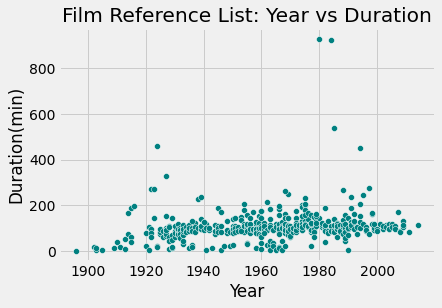

In [10]:
sns.scatterplot(data=ref_full, x='Year', y="Duration(min)", color="teal").set_title("Film Reference List: Year vs Duration") # Make regular scatterplot
plt.savefig("Year_vs_Duration.jpg", dpi=250, bbox_inches='tight')

It looks like some outliers are interferring with our hability to see the relationship. Given how lengthy some of those are, I'm guessing they are series, rather than single feature films. Let's make an interactive plot so we can hover over the points and see the title of each film to see if that's true. We can also select an area of the plot to Zoom in.

In [11]:
# Interactive plot
fig = px.scatter(ref_full, x='Year', y="Duration(min)", hover_name="English Title")
fig.show()

Indeed, the two points with the highest duration are series ("Berlin Alexanderplatz" and "Heimat"), but others, like "Shoah" and "Greed" are not. On the other side of the spectrum, we notice that there are several short films on the list, particularly in the first decades of cinema.  They become increasingly rare on the list after the mid-60s, indicating a decrease in the format's perceived cultural importance (though if they also diminished in volume as a percentage of all films is quite another question, which this dataset could not answer). 

If we were interested exclusively in identifying a general trend regarding the length of feature films, it would be helpful to remove the outliers. We can use the definition of the [AMPAS](https://www.oscars.org/sites/oscars/files/93aa_rules.pdf) and [BFI](https://www.bfi.org.uk/bfi-national-archive/research-bfi-archive/bfi-filmography/bfi-filmography-faq), which both use the mark of 40 minutes to separate shorts and features. The opposite end of the spectrum is much harder to cut off. A 300 minute line (5 hours) would be a very generous limit.

In [12]:
# Make new dataframe without films shorter than 40 min and longer than 300 min
feature_length = ref_full[(ref_full['Duration(min)'] < 300) & (ref_full['Duration(min)'] > 40)]
# Simplify this dataframe with only the columns we need
feature_length = feature_length[["Year", "Duration(min)", "English Title"]]

In [13]:
feature_length

,Year,Duration(min),English Title
8,1913,54,Fantomas: In the Shadow of the Guillotine
10,1914,168,Cabiria
11,1914,74,The Squaw Man
12,1915,187,The Birth of a Nation
13,1915,59,Carmen
...,...,...,...
424,2009,104,Antichrist
425,2009,131,The Hurt Locker
426,2009,115,"Police, Adjective"
427,2011,82,Tomboy


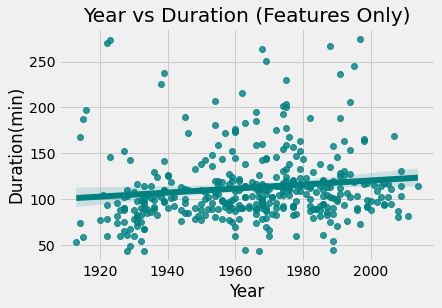

In [14]:
# Plot only films with more than 40 and less than 300 min with a regression line
sns.regplot(data=feature_length, x="Year", y="Duration(min)", color="teal").set_title("Year vs Duration (Features Only)")
plt.savefig("Features_Year_vs_Duration.jpg", dpi=250, bbox_inches='tight')

In [15]:
# Let's check to see what is the correlation and level of significance
X = feature_length['Year']
Y = feature_length["Duration(min)"]
linregress(X, Y)

LinregressResult(slope=0.21986085229944013, intercept=-319.2384756782228, rvalue=0.12994664407050588, pvalue=0.011444832975126294, stderr=0.08651488367240102, intercept_stderr=169.95040926103582)

That means the correlation is 0.13 (very weak) and the significance is 0.01 (very low). This indicates that movies on the reference list tend to get longer throughout the period (120 years) and, while there are other factors that influence film length to a considerable degree outside of the period in which they were made, there is a very low chance (1%) that this relationship is just a quirk of our data. It would be interesting to check with a larger and more random sample (not just including canonical films) to see if this is the case for films in general.

# Distribution of films per year
We can see from this data that the movies in the reference list aren't distributed across the years very well. Let's make *a* histogram to see how they are distributed.

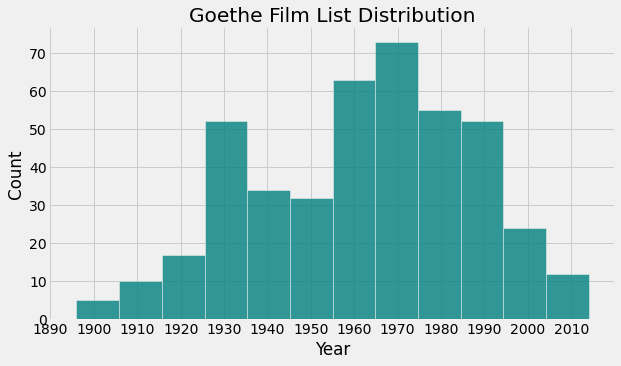

In [16]:
# Histogram for the distribution
plt.figure(figsize=(9, 5))
sns.histplot(ref_full["Year"], bins=12, color="teal", alpha=0.8).set_title("Goethe Film List Distribution")# Organized in 12 bins so we have one per decade (from 1890 to 2010)
sns.despine(left=True, bottom=True)
plt.xticks(range(1890, 2020, 10)) # x ticks in our range of years and after every 10 years, so we can see each decade
plt.savefig("Year_Distribution.jpg", dpi=250, bbox_inches='tight')

The 60s and 70s are the most represented, perhaps indicating something about the age the creators of the reference list are nostalgic about. 

Next, we can check the frequency of non-numerical data, such as gender and country of origin.

# Gender Split (Pie Chart)

In [17]:
# First we need to take just the gender of director and count
# Our dataframe sometimes has multiple directors in one row, separated by /
# In order to count gender, we could make three categories: male (if all directors are male), female (if all are female) and mixed (if there is a mixed team per film). That way, we don't count movies twice
ref_full["Director's Gender"].value_counts(normalize=True)

male                                  0.792541
female                                0.123543
male/ male                            0.060606
male/ female                          0.006993
female/ male                          0.006993
male/ male/ male/ male/ male/ male    0.002331
male/ male/ male                      0.002331
male/ male/ male/ male/ male          0.002331
female/ male/ male                    0.002331
Name: Director's Gender, dtype: float64

In [18]:
# New dataframe with just the information we need: year and director's Gender
dir_gender = ref_full[["Year", "Director's Gender"]]

In [19]:
dir_gender["Director's Gender"].isnull().values.any()

False

In [20]:
# Transform cells with multiple directors
dir_gender["Director's Gender"] = dir_gender["Director's Gender"].apply(lambda row: 'male' if 'female' not in row else row) # If "female" not in cell, replace cell value with "male"
dir_gender["Director's Gender"] = dir_gender["Director's Gender"].apply(lambda row: 'mixed' if '/' in row else row) # If / in row (which is now only present in movies with mixed or exclusively female directors), replace value with "mixed"

<ipython-input-20-22d2f82652b8>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-22d2f82652b8>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
# Let's see the numbers
dir_gender["Director's Gender"].value_counts()

male      369
female     53
mixed       7
Name: Director's Gender, dtype: int64

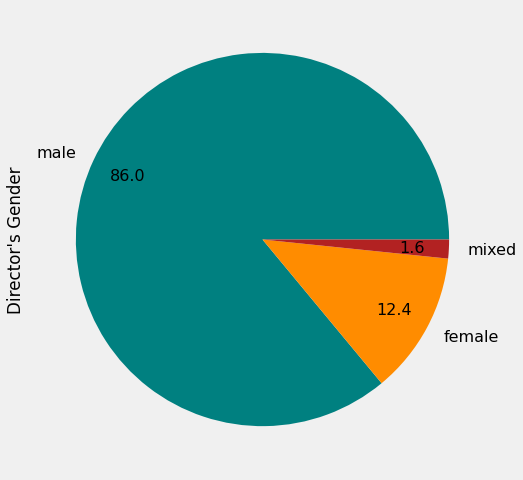

In [22]:
# Let's make a piechart
dir_gender["Director's Gender"].value_counts().plot.pie(subplots=True, figsize=(12,8), autopct="%.1f", fontsize=16, pctdistance=0.8, colors=["teal","darkorange", "firebrick"])
plt.savefig("Director_Gender_Pie.jpg", dpi=250, bbox_inches='tight')

# Gender Distribution Through the Years (Stacked Bar Chart)

A pie chart is fine if we want to have a static idea of the representation of film director's by gender, but it doesn't allow us to see the distribution in time. A stacked by chart could show us both the skewed distribution of films per year and the gender split in a single chart.

In [23]:
# Let's sort the three types of film into three dataframes
films_men = dir_gender[dir_gender["Director's Gender"] == "male"]
films_women = dir_gender[dir_gender["Director's Gender"] == "female"]
films_mixed = dir_gender[dir_gender["Director's Gender"] == "mixed"]

In [24]:
# Let's count the number of films per year in each category
women_count = films_women.groupby("Year").count()
men_count = films_men.groupby("Year").count()
mixed_count = films_mixed.groupby("Year").count()

In [25]:
# Let's check to see how many films have director's of mixed gender
mixed_count

,Director's Gender
Year,
1913,1
1930,1
1941,1
1943,1
1968,2
1977,1


In [26]:
# This will change the names of each column and turn the dates into indexes, so we can join everything into one dataframe with three columns
men_count.rename(columns={"Director's Gender": 'Male'}, inplace=True)
women_count.rename(columns={"Director's Gender": 'Female'}, inplace=True)
mixed_count.rename(columns={"Director's Gender": 'Mixed'}, inplace=True)

In [27]:
# Join the dataframes 
gender_count = pd.concat([men_count,women_count, mixed_count], axis=1)

In [28]:
# Let's see what it looks like
gender_count

,Male,Female,Mixed
Year,,,
1896,NaN,1.0,NaN
1902,1.0,NaN,NaN
1903,2.0,NaN,NaN
1905,1.0,NaN,NaN
1909,1.0,NaN,NaN
...,...,...,...
2007,NaN,1.0,NaN
2008,2.0,NaN,NaN
2009,2.0,1.0,NaN


In [29]:
# Let's fill the empty cell values with the number 0
gender_count = gender_count.fillna(0)

In [30]:
gender_count

,Male,Female,Mixed
Year,,,
1896,0.0,1.0,0.0
1902,1.0,0.0,0.0
1903,2.0,0.0,0.0
1905,1.0,0.0,0.0
1909,1.0,0.0,0.0
...,...,...,...
2007,0.0,1.0,0.0
2008,2.0,0.0,0.0
2009,2.0,1.0,0.0


In [31]:
# For a stacked barchart, we need to decide which group goes in which order of the chart. Typically, it should be from largest to smallest.
male_films1 = gender_count["Male"]
female_films2 = gender_count["Female"]
mixed_films3 = gender_count["Mixed"]

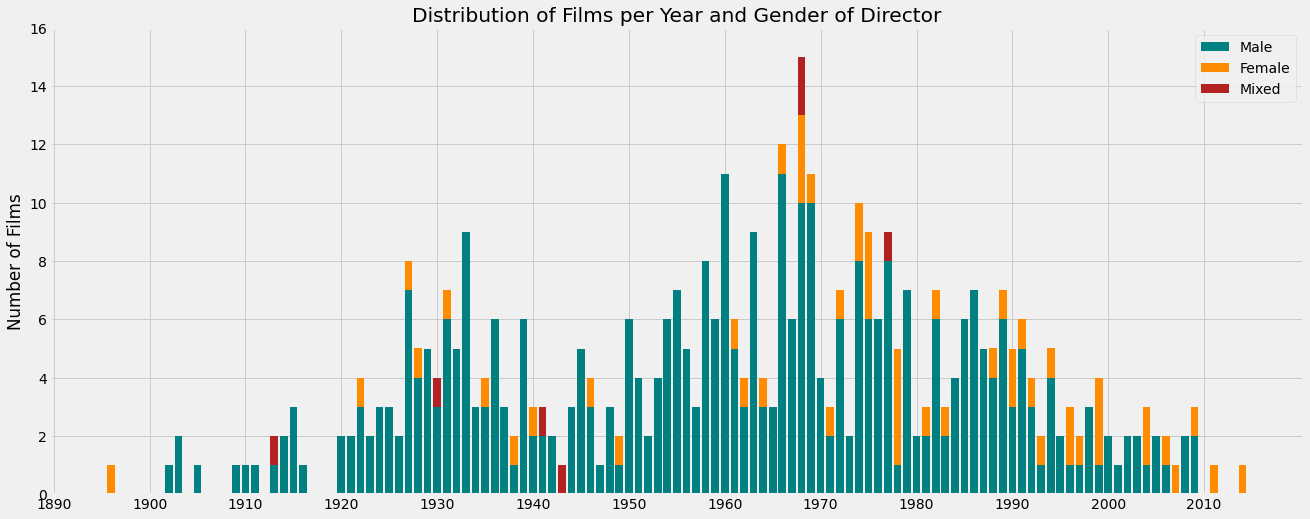

In [32]:
# To make a stacked bar chart, make the first bar chart normally, then make those on top with on top of that by using the keyword "bottom"
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 8))
plt.bar(gender_count.index, male_films1, color="teal") 
plt.bar(gender_count.index, female_films2, bottom=male_films1, color="darkorange")
plt.bar(gender_count.index, mixed_films3, bottom=male_films1+female_films2, color="firebrick")
plt.legend(["Male", "Female", "Mixed"])
plt.title("Distribution of Films per Year and Gender of Director")
plt.xticks(range(1890, 2014, 10))
plt.yticks(range(0, 18, 2))
plt.ylabel("Number of Films")
plt.savefig("Gender_Year_Distribution.jpg", dpi=250, bbox_inches='tight')

### Country Count

There are several films there are co-productions, which means they are not counted together with the individual countries. There are different ways of solving this: we could transform co-productions into its own category, or we could separate the co-productions into the individual countries and count them again. The first solution would homogenize all co-productions, while the second one would count the same films multiple times. Since I am primarily interested in the proportion of films per country for reasons of representation, I will take the second course of action, given that co-productions should, in my opinion, count for a country's percentage. The downside of this strategy is that co-productions will be counted more than once.

In [33]:
country_count = ref_full[["Country"]]

In [34]:
country_count = country_count.drop('Country', axis=1).join(country_count['Country'].str.split('/ ', expand=True).stack().reset_index(level=1, drop=True).rename('Country'))

In [35]:
country_count

,Country
0,FRA
1,FRA
2,USA
3,USA
4,GBR
...,...
426,ROU
427,FRA
428,DEU
428,GBR


In [36]:
# Run the count_frequency function to create a data frame with the frequency of countries
frequent_countries = count_frequency(country_count, "Country")

In [37]:
frequent_countries

,Country,Number of Items,Frequency
0,USA,160,0.299065
1,FRA,93,0.173832
2,DEU,60,0.112150
3,ITA,39,0.072897
4,GBR,30,0.056075
5,IND,16,0.029907
6,JPN,14,0.026168
7,HKG,13,0.024299
8,SUN,11,0.020561
9,SWE,7,0.013084


There are 45 unique countries on our list. A bar chart with all would a bit too long and hard to read, so before we make a visualization, we could group the countries with few films under "Others". Here is where we'll use the function "group_others" from the beginning.

In [38]:
# Run group_others function with 1% or less.
countries_over_1pct = group_others(frequent_countries, 'Country', 0.01)
print(countries_over_1pct)

   Country  Number of Items  Frequency
0      USA              160   0.299065
1      FRA               93   0.173832
2      DEU               60   0.112150
3      ITA               39   0.072897
4      GBR               30   0.056075
5      IND               16   0.029907
6      JPN               14   0.026168
7      HKG               13   0.024299
8      SUN               11   0.020561
9      SWE                7   0.013084
10     AUT                6   0.011215
11     CHE                6   0.011215
12     CHN                6   0.011215
13     POL                6   0.011215
14  Others               68   0.127103


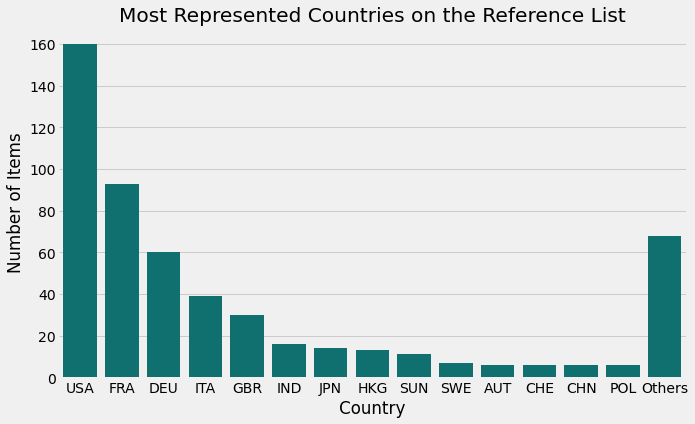

In [39]:
# Let's visualize this data with a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=countries_over_1pct, x="Country", y="Number of Items", color="teal")
plt.title("Most Represented Countries on the Reference List")
sns.despine(left=True, bottom=True)
plt.savefig("Countries_over_1pct_VerticalBar.jpg", dpi=250, bbox_inches='tight')
plt.show()

In [40]:
# Let's take a look at it with a pie chart. We need fewer slices to make it readable, so let's group those with 5% or less
countries_over_5pct = group_others(frequent_countries, 'Country', 0.05)

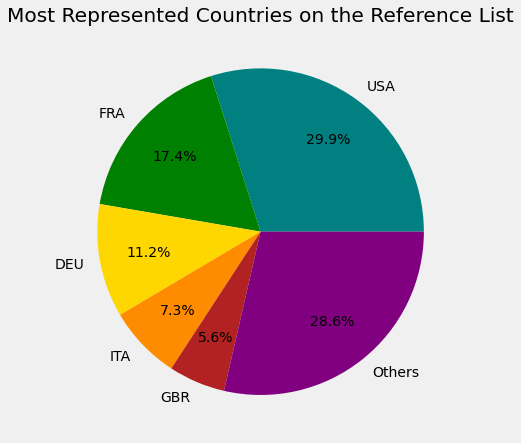

In [41]:
# Pie chart
plt.figure(figsize=(9, 7))
plt.pie(countries_over_5pct["Number of Items"], labels = countries_over_5pct["Country"], autopct='%1.1f%%', pctdistance=0.7, colors=["teal", "green", "gold", "darkorange", "firebrick", "purple"])
plt.title("Most Represented Countries on the Reference List")
plt.savefig("Countries_Pie.jpg", dpi=250, bbox_inches='tight')